In [34]:
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

%matplotlib inline

In [17]:
forecast_csvs = list(Path('../data/').glob('*_forecast.csv'))
forecast_dict = {path.name.split("_")[0]: path for path in forecast_csvs}
print(forecast_dict)

NA_INDEX = list()

with open('../models/rf_model.pkl', 'rb') as f:
    model = pickle.loads(f.read())

with open('../models/data_scaler.pkl', 'rb') as f:
    scaler = pickle.loads(f.read())

print("model loaded")
print("scaler loaded")

{'IAD': PosixPath('../data/IAD_weather_forecast.csv'), 'ORD': PosixPath('../data/ORD_weather_forecast.csv'), 'DEN': PosixPath('../data/DEN_weather_forecast.csv'), 'SYR': PosixPath('../data/SYR_weather_forecast.csv'), 'EWR': PosixPath('../data/EWR_weather_forecast.csv')}
model loaded
scaler loaded


In [18]:
model

RandomForestClassifier(criterion='log_loss', max_depth=90, min_samples_leaf=4,
                       min_samples_split=5, n_estimators=125, random_state=69)

In [19]:
inference_df = pd.read_csv('../data/inference/project csv(Apr 12-15).csv')
inference_df.head()

,Date,Day,Origin Airport,Flight Number,Arrival Time,"Status (Early, On-time, Late, Severly Late)"
0,4/12/2023,Wednesday,ORD,UA 3839,10:00 AM,NaN
1,4/12/2023,Wednesday,ORD,UA 3524,4:52 PM,NaN
2,4/12/2023,Wednesday,ORD,UA 538,9:34 PM,NaN
3,4/13/2023,Thursday,ORD,UA 3839,10:00 AM,NaN
4,4/13/2023,Thursday,ORD,UA 3524,4:50 PM,NaN


In [20]:
def preprocess_inference_df(df):
    
    global NA_INDEX
    
    na_indices1 = df.loc[df['Arrival Time'].isna(), :].index.tolist()
    na_indices2 = df.loc[df['Date'].isna(), :].index.tolist()
    df['original_index'] = df.index
    
    NA_INDEX += na_indices1
    NA_INDEX += na_indices2
    
    # drop irrelevant rows.
    df = df.loc[~df['Arrival Time'].isna(), :]
    df = df.loc[~df['Date'].isna(), :]
    
    df.Date = pd.to_datetime(df.Date)
    df['Arrival Time'] = pd.to_datetime(df['Arrival Time'])
    df['Arrival Time (Rounded)'] = df['Arrival Time'].dt.round('H')
    df['Date (MM/DD/YYYY)'] = df['Date']
    df.drop(columns=['Arrival Time', 'Day', 'Flight Number', 'Date'], axis='columns', inplace=True)
    df['Arrival Time (Rounded)'] = df['Arrival Time (Rounded)'].apply(lambda x: x.time())
    return df

In [21]:
df = preprocess_inference_df(inference_df)

In [22]:
display(df.head())

,Origin Airport,"Status (Early, On-time, Late, Severly Late)",original_index,Arrival Time (Rounded),Date (MM/DD/YYYY)
0,ORD,NaN,0,10:00:00,2023-04-12
1,ORD,NaN,1,17:00:00,2023-04-12
2,ORD,NaN,2,22:00:00,2023-04-12
3,ORD,NaN,3,10:00:00,2023-04-13
4,ORD,NaN,4,17:00:00,2023-04-13


In [55]:
def join_weather_data(root_df):
    
    city_dfs = []
    
    for city in set(forecast_dict.keys()).difference({'SYR'}):
        print("Merging data for ", city, "...")
        
        sub_df = root_df.loc[root_df['Origin Airport'] == city, :]
        print(f"{sub_df.shape[0]} records for {city}...")
        
        city_df = pd.read_csv(forecast_dict[city])
        print(city_df.shape)
        city_df['time'] = pd.to_datetime(city_df['time'])
        city_df['Date'] = pd.to_datetime(city_df['time'].apply(lambda x: x.date()))
        city_df['Time'] = city_df['time'].apply(lambda x: x.time())
        city_df.drop(columns=['Unnamed: 0', 'time'], inplace=True, axis='columns')
        
        # Now join with the root_df
        merged_df = sub_df.merge(
            right=city_df,
            left_on=['Date (MM/DD/YYYY)', 'Arrival Time (Rounded)'],
            right_on=['Date', 'Time'],
            how='inner'
        )
        
        display(merged_df[['Date (MM/DD/YYYY)', 'Arrival Time (Rounded)', 'Date', 'Time']])
        
        city_dfs.append(merged_df)
    
    root_df = pd.concat(city_dfs, axis=0)
    
    # Now join SYR
    print("Merging SYR data...")
    syr_df = pd.read_csv(forecast_dict['SYR'])
    syr_df['time'] = pd.to_datetime(syr_df['time'])
    syr_df['Date'] = pd.to_datetime(syr_df['time'].apply(lambda x: x.date()))
    syr_df['Time'] = syr_df['time'].apply(lambda x: x.time())
    
    syr_df.drop(columns=['Unnamed: 0', 'time'], inplace=True, axis='columns')
    syr_df.columns = ['syr_' + x for x in syr_df.columns]
    
    root_df = root_df.merge(
        right=syr_df,
        left_on=['Date (MM/DD/YYYY)', 'Arrival Time (Rounded)'],
        right_on=['syr_Date', 'syr_Time'],
        how='inner'
    )
    
    return root_df

In [56]:
merged_df = join_weather_data(df)

Merging data for  ORD ...
12 records for ORD...
(168, 20)


,Date (MM/DD/YYYY),Arrival Time (Rounded),Date,Time
0,2023-04-12,10:00:00,2023-04-12,10:00:00
1,2023-04-12,17:00:00,2023-04-12,17:00:00
2,2023-04-12,22:00:00,2023-04-12,22:00:00
3,2023-04-13,10:00:00,2023-04-13,10:00:00
4,2023-04-13,17:00:00,2023-04-13,17:00:00
5,2023-04-13,22:00:00,2023-04-13,22:00:00
6,2023-04-14,10:00:00,2023-04-14,10:00:00
7,2023-04-14,17:00:00,2023-04-14,17:00:00
8,2023-04-14,22:00:00,2023-04-14,22:00:00
9,2023-04-15,10:00:00,2023-04-15,10:00:00


Merging data for  IAD ...
8 records for IAD...
(168, 20)


,Date (MM/DD/YYYY),Arrival Time (Rounded),Date,Time
0,2023-04-12,14:00:00,2023-04-12,14:00:00
1,2023-04-12,19:00:00,2023-04-12,19:00:00
2,2023-04-13,14:00:00,2023-04-13,14:00:00
3,2023-04-13,19:00:00,2023-04-13,19:00:00
4,2023-04-14,14:00:00,2023-04-14,14:00:00
5,2023-04-14,19:00:00,2023-04-14,19:00:00
6,2023-04-15,14:00:00,2023-04-15,14:00:00
7,2023-04-15,19:00:00,2023-04-15,19:00:00


Merging data for  DEN ...
4 records for DEN...
(168, 20)


,Date (MM/DD/YYYY),Arrival Time (Rounded),Date,Time
0,2023-04-12,15:00:00,2023-04-12,15:00:00
1,2023-04-13,15:00:00,2023-04-13,15:00:00
2,2023-04-14,15:00:00,2023-04-14,15:00:00
3,2023-04-15,15:00:00,2023-04-15,15:00:00


Merging data for  EWR ...
8 records for EWR...
(168, 20)


,Date (MM/DD/YYYY),Arrival Time (Rounded),Date,Time
0,2023-04-12,11:00:00,2023-04-12,11:00:00
1,2023-04-12,00:00:00,2023-04-12,00:00:00
2,2023-04-13,11:00:00,2023-04-13,11:00:00
3,2023-04-13,00:00:00,2023-04-13,00:00:00
4,2023-04-14,11:00:00,2023-04-14,11:00:00
5,2023-04-14,00:00:00,2023-04-14,00:00:00
6,2023-04-15,11:00:00,2023-04-15,11:00:00
7,2023-04-15,23:00:00,2023-04-15,23:00:00


Merging SYR data...


In [57]:
merged_df.drop(
    columns=[
        'Arrival Time (Rounded)',
        'Date (MM/DD/YYYY)',
        'Date',
        'Time',
        'syr_Date',
        'syr_Time'
    ], axis='columns', inplace=True
)

In [58]:
merged_df.shape

(32, 39)

In [59]:
X_test = merged_df.loc[:, ~merged_df.columns.isin([
    'Status (Early, On-time, Late, Severly Late)', 'original_index', 'Origin Airport'
])]
X_test_scaled = scaler.transform(X_test)
print("Data scaled")

Data scaled


In [60]:
preds = model.predict(X_test)
assert len(preds) == merged_df.shape[0]

In [61]:
merged_df['Status (Early, On-time, Late, Severly Late)'] = preds

In [62]:
for ix in range(merged_df.shape[0]):
    original_index = merged_df.original_index[ix]
    predicted_value = merged_df['Status (Early, On-time, Late, Severly Late)'][ix]
    inference_df.loc[original_index, 'Status (Early, On-time, Late, Severly Late)'] = predicted_value

In [63]:
def postprocess(val):
    if val == 'delayed':
        return 'Late'
    if val == 'on_time':
        return 'On-time'
    if val == 'severely_delayed':
        return "Severely Late"
    
    return "Early"

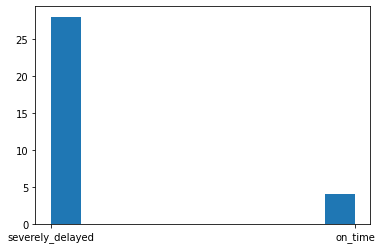

In [64]:
fig, ax = plt.subplots()
ax.hist(preds)
plt.show()

In [65]:
inference_df['Status (Early, On-time, Late, Severly Late)'] = inference_df[
    'Status (Early, On-time, Late, Severly Late)'
].apply(lambda x: postprocess(x))

# inference_df.drop(columns=['original_index'], axis='columns', inplace=True)

display(inference_df.head())

,Date,Day,Origin Airport,Flight Number,Arrival Time,"Status (Early, On-time, Late, Severly Late)"
0,4/12/2023,Wednesday,ORD,UA 3839,10:00 AM,Severely Late
1,4/12/2023,Wednesday,ORD,UA 3524,4:52 PM,Severely Late
2,4/12/2023,Wednesday,ORD,UA 538,9:34 PM,Severely Late
3,4/13/2023,Thursday,ORD,UA 3839,10:00 AM,Severely Late
4,4/13/2023,Thursday,ORD,UA 3524,4:50 PM,Severely Late


In [66]:
inference_df.to_csv('../data/inference/PREDICTED_CSV (12-15).csv', index=False)